In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
import pandas as p 
train=p.read_csv("/Users/kenmckee/Desktop/dscd.csv", delimiter=',') 
ID=train['courseID'].values 
synopses=train['courseDesc'].values 
titles=train['courseTitle'].values

In [3]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [4]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [5]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'courseDesc', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [7]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 581 items in vocab_frame


In [8]:
print(vocab_frame.head())
print
print
print
print

               words
definit   definition
develop  development
and              and
manag     management
of                of


<function print>

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=400,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 20 ms, sys: 1.81 ms, total: 21.8 ms
Wall time: 20.4 ms
(20, 18)


In [10]:
terms = tfidf_vectorizer.get_feature_names()

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>

In [11]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 190 ms, sys: 3.38 ms, total: 194 ms
Wall time: 194 ms


In [12]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [13]:
films = { 'title': titles,'synopsis': synopses, 'cluster': clusters, 'ID': ID}

frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'cluster', 'ID'])
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

grouped = frame['cluster'].groupby(frame['title']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()




Top terms per cluster:

Cluster 0 words: b'hands-on', b'management', b'development', b'using', b'modeling', b'students',

Cluster 0 titles: Enterprise Technologies, Creating Managing and Preserving Digital Assets, Metadata,

Cluster 1 words: b'students', b'techniques', b'introduction', b'technologies', b'project', b'information',

Cluster 1 titles: Managing Information Systems Projects, Natural Language Processing, Advanced Information Analytics, Information Visualization,

Cluster 2 words: b'applications', b'analysis', b'techniques', b'methods', b'concepts', b'data',

Cluster 2 titles: Data Mining, Information Systems Analysis, Text Mining,

Cluster 3 words: b'information', b'using', b'tools', b'technologies', b'hands-on', b'project',

Cluster 3 titles: Information Architecture for Internet Services, Basics of Information Retrieval Systems, Foundations of Digital Data, Research Methods in Information Science and Technology, Statistical Methods in Information Science and Technology,

C

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [14]:
frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

4    5
3    5
1    4
2    3
0    3
Name: cluster, dtype: int64

In [15]:
grouped = frame['ID'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0    665.666667
1    686.500000
2    651.666667
3    687.800000
4    679.000000
Name: ID, dtype: float64

In [16]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()


In [29]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'hands-on, management, development', 
                 1: 'techniques, technology, introduction', 
                 2: 'applications, analysis, methods', 
                 3: 'information, using, tools', 
                 4: 'data, management, concepts'}

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


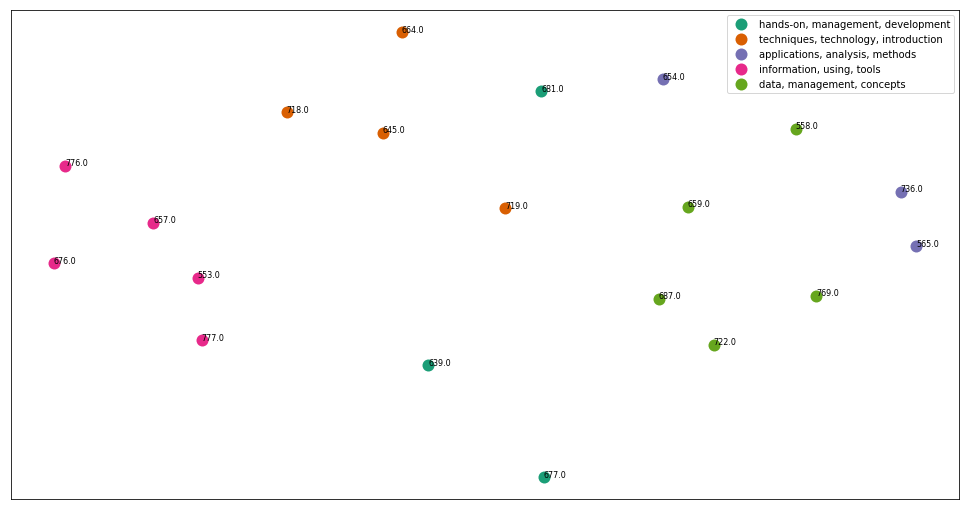

In [31]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=ID)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


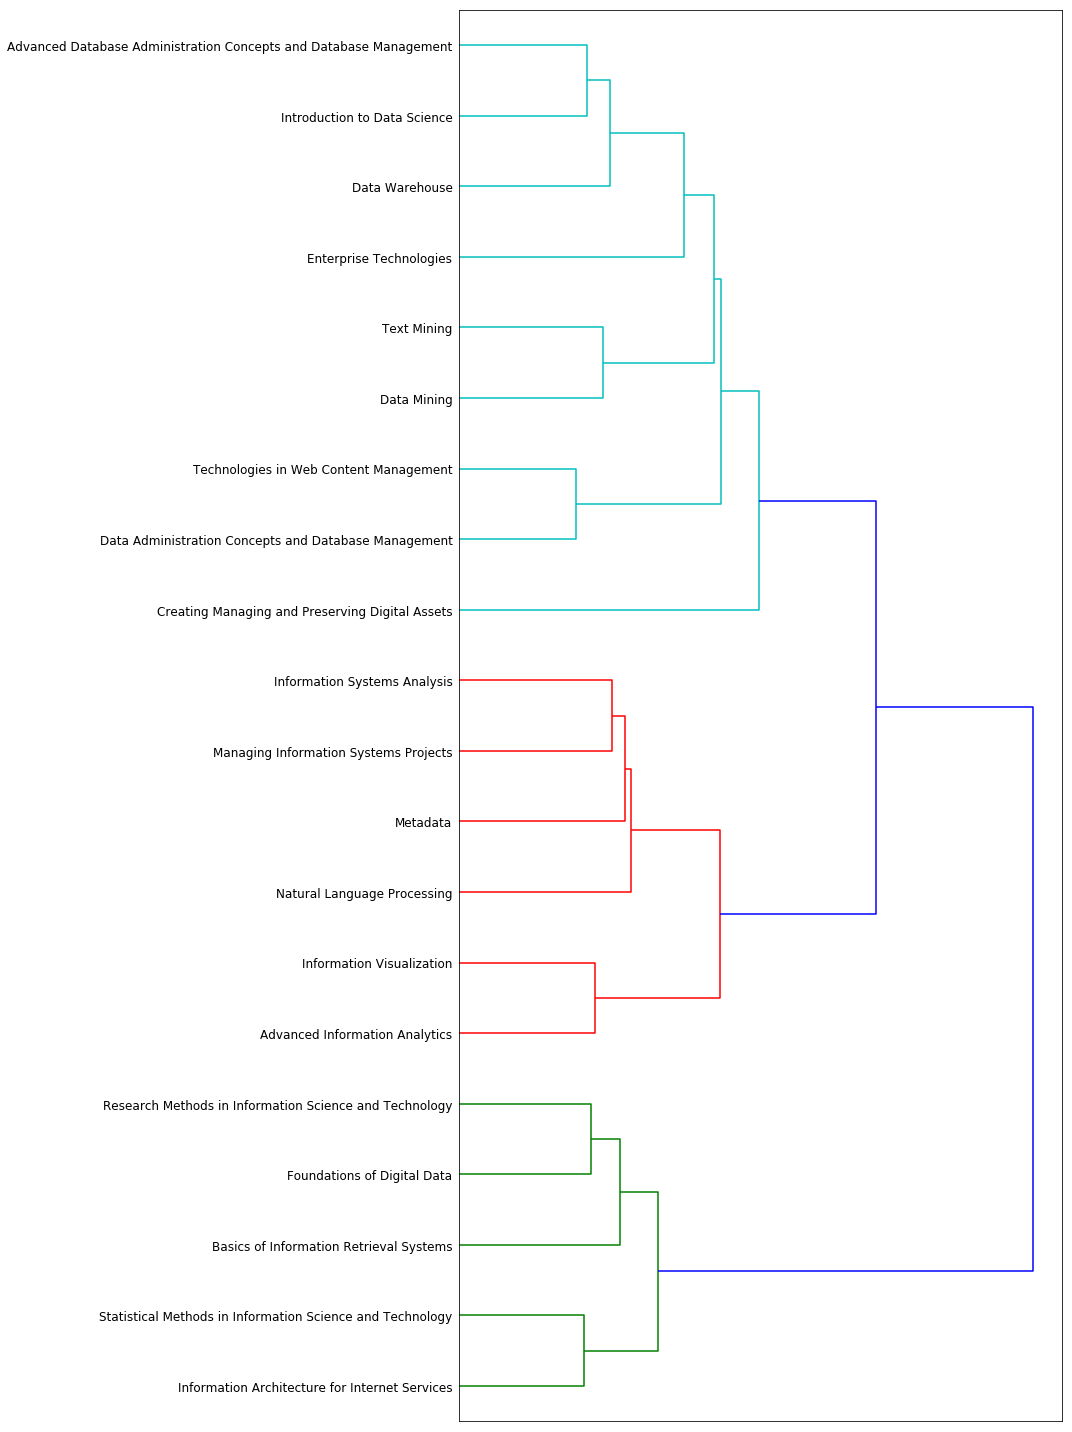

In [19]:
plt.close()

#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters


In [20]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()


#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in ]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

%time 
lda = models.LdaModel(corpus, num_topics=5, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=10000, 
                            passes=100)



CPU times: user 9 ms, sys: 21 µs, total: 9.02 ms
Wall time: 9.04 ms
CPU times: user 13.9 ms, sys: 246 µs, total: 14.1 ms
Wall time: 14.1 ms
CPU times: user 764 µs, sys: 2 µs, total: 766 µs
Wall time: 772 µs
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [21]:
lda.show_topics()



[(0,
  '0.075*"databas" + 0.029*"data" + 0.029*"manag" + 0.020*"model" + 0.020*"analysi" + 0.020*"includ" + 0.020*"system" + 0.020*"develop" + 0.020*"organ" + 0.020*"specif"'),
 (1,
  '0.028*"project" + 0.028*"comput" + 0.021*"system" + 0.021*"enterpris" + 0.021*"requir" + 0.021*"solut" + 0.021*"technolog" + 0.021*"manag" + 0.021*"inform" + 0.015*"process"'),
 (2,
  '0.059*"research" + 0.045*"digit" + 0.045*"inform" + 0.045*"procedur" + 0.031*"transfer" + 0.031*"librari" + 0.017*"retriev" + 0.017*"practic" + 0.017*"environ" + 0.017*"process"'),
 (3,
  '0.055*"data" + 0.047*"inform" + 0.040*"manag" + 0.024*"use" + 0.024*"technolog" + 0.024*"techniqu" + 0.024*"metadata" + 0.017*"profession" + 0.017*"tool" + 0.017*"qualiti"'),
 (4,
  '0.043*"applic" + 0.030*"techniqu" + 0.030*"data" + 0.030*"text" + 0.030*"mine" + 0.016*"concept" + 0.016*"experi" + 0.016*"hands-on" + 0.016*"intellig" + 0.016*"busi"')]

In [22]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

ValueError: setting an array element with a sequence